In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image

import torch
from torch.autograd import Variable
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
class CustomCityScapeDS(Dataset):
    def __init__(self, root = None, split = "train", mode = "fine", 
                 transform = None, sematic_transform = None):
        self.split = split
        self.mode = mode
        self.images = []
        self.targets = []
        self.target_transform = {}

        self.semantic_map = {
            0 : ['unlabeled', 19, 'void'], 
            1 : ['ego vehicle', 19, 'void'],
            2 : ['rectification border', 19, 'void'],
            3 : ['out of roi', 19, 'void'],
            4 : ['static', 19, 'void'],
            5 : ['dynamic', 19, 'void'],
            6 : ['ground', 19, 'void'],
            7 : ['road', 0, 'flat'],
            8 : ['sidewalk', 1, 'flat'],
            9 : ['parking', 19, 'flat'],
            10 : ['rail track', 19, 'flat'],
            11 : ['building', 2, 'construction'],
            12 : ['wall', 3, 'construction'],
            13 : ['fence', 4, 'construction'],
            14 : ['guard rail', 19, 'construction'],
            15 : ['bridge', 19, 'construction'],
            16 : ['tunnel', 19, 'construction'],
            17 : ['pole', 5, 'object'],
            18 : ['polegroup', 19, 'object'],
            19 : ['traffic light', 6, 'object'],
            20 : ['traffic sign', 7, 'object'],
            21 : ['vegetation', 8, 'nature'],
            22 : ['terrain', 9, 'nature'],
            23 : ['sky', 10, 'sky'],
            24 : ['person', 11, 'human'],
            25 : ['rider', 12, 'human'],
            26 : ['car', 13, 'vehicle'],
            27 : ['truck', 14, 'vehicle'],
            28 : ['bus', 15, 'vehicle'],
            29 : ['caravan', 19, 'vehicle'],
            30 : ['trailer', 19, 'vehicle'],
            31 : ['train', 16, 'vehicle'],
            32 : ['motorcycle', 17, 'vehicle'],
            33 : ['bicycle', 18, 'vehicle'],
            34 : ['license plate', -1, 'vehicle']
        }
        
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.Compose([transforms.Resize((256, 512)), transforms.ToTensor()])
        
        if sematic_transform:
            self.target_transform['semantic'] = sematic_transform
        else:
            self.target_transform['semantic'] = transforms.Compose(
                [transforms.Resize((256, 512)), transforms.PILToTensor(), self.make_semantic_class])

        self.root = "/media/mountHDD2/cityscapes" if not root else root

        if self.mode == "fine":
            if self.split not in ['train', 'val', 'test']:
                raise ValueError("self.split has to be one of ['train', 'val', 'test']")
        elif self.mode == "coarse":
            if self.split not in ['train', 'train_extra', 'val']:
                raise ValueError("self.split has to be one of ['train', 'train_extra', 'val']")
        else:
            raise Value_colorError(f"mode cannot be {self.mode}")

        self.img_dir = self.root + f"/leftImg8bit/{self.split}"
        self.mode_folder = "gtFine" if self.mode == "fine" else "gtCoarse"
        self.semantic_dir = self.root + f"/{self.mode_folder}/{self.split}"
        self.depth_dir = self.root + f"/disparity/{self.split}"

        for check_dir in [self.img_dir, self.semantic_dir, self.depth_dir]:
            if not os.path.exists(check_dir):
                print(f"The dataset source is not available or not extracted at {self.root}")

        print("Data Set Setting Up")
        for city in tqdm(os.listdir(self.img_dir)):
            img_dir = os.path.join(self.img_dir, city)
            semantic_target_dir = os.path.join(self.semantic_dir, city)
            depth_target_dir = os.path.join(self.depth_dir, city)
            for file_name in os.listdir(img_dir):
                self.images.append(os.path.join(img_dir, file_name))

                fn = file_name.split("_leftImg8bit")[0]
                mode_folder = semantic_target_dir.split("/")[-3]

                self.targets.append(
                    {
                        "semantic" : os.path.join(semantic_target_dir, f"{fn}_{mode_folder}_labelIds.png"),
                        "depth" : os.path.join(depth_target_dir, f"{fn}_disparity.png"),
                    }
                )
                
        print("Done")
    
    def make_semantic_class(self, x):
        encx = torch.zeros(x.shape, dtype=torch.long)
        for label in self.semantic_map:
            encx[x == label] = self.semantic_map[label][1]
        onehot = F.one_hot(encx.squeeze(1), 20).permute(0, 3, 1, 2)[0].float()
        return onehot[:-1]

    def process_depth(self, x):
        depth = cv2.imread(x, cv2.IMREAD_UNCHANGED).astype(np.float32)
        depth = cv2.resize(depth, (512, 256))
        depth[depth > 0] = (depth[depth > 0] - 1) / 256
        
        # depth = 0.209313 * 2262.52 / depth

        depth[depth == np.inf] = 0
        depth[depth == np.nan] = 0
        depth[depth < 0] = 0

        # depth = np.minimum(depth, 100) 

        torch_depth = torch.from_numpy(depth).unsqueeze(0) / 255.0

        return torch_depth

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.transform(Image.open(self.images[idx]).convert("RGB"))

        target = {}
        target['semantic'] = self.target_transform['semantic'](Image.open(self.targets[idx]['semantic']))
        target['depth'] = self.process_depth(self.targets[idx]['depth'])

        return img, target

In [3]:
train_fine_ds = CustomCityScapeDS(split = 'train', mode = 'fine')
valid_fine_ds = CustomCityScapeDS(split = 'val', mode = 'fine')
test_fine_ds = CustomCityScapeDS(split = 'test', mode = 'fine')

print(len(train_fine_ds))
print(len(valid_fine_ds))
print(len(test_fine_ds))

Data Set Setting Up


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1923.06it/s]


Done
Data Set Setting Up


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1976.58it/s]


Done
Data Set Setting Up


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1353.15it/s]

Done
2975
500
1525


In [4]:
train_fine_dl = DataLoader(train_fine_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
valid_fine_dl = DataLoader(valid_fine_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
test_fine_dl = DataLoader(test_fine_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Batch: {}".format(len(train_fine_dl)))
print("#Validation Batch: {}".format(len(valid_fine_dl)))
print("#Testing Batch: {}".format(len(test_fine_dl)))

#Training Batch: 93
#Validation Batch: 16
#Testing Batch: 48


data shape: torch.Size([3, 256, 512])
semantic_target shape: torch.Size([19, 256, 512])
depth_target shape: torch.Size([1, 256, 512])
Number classes: 19
Classes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18])


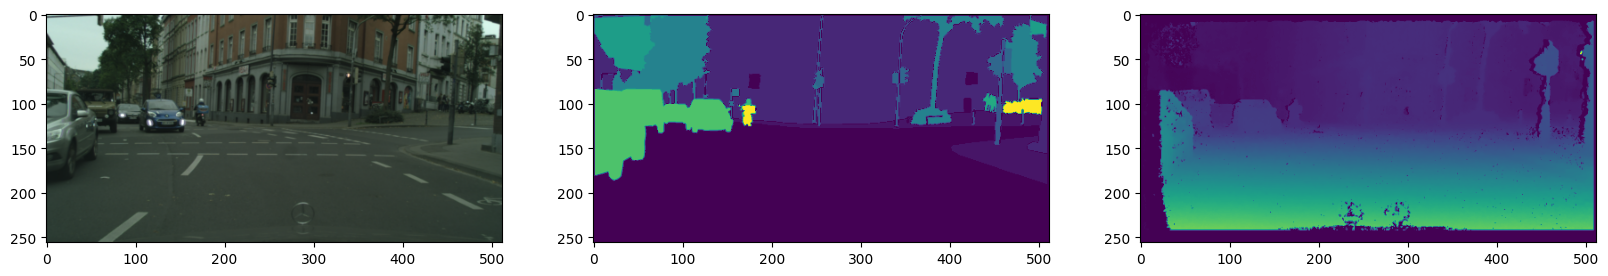

In [5]:
for idx in range(1):
    data, target = train_fine_ds[idx]

    semantic_target = target['semantic']
    depth_target = target['depth']
    
    print(f"data shape: {data.shape}")
    print(f"semantic_target shape: {semantic_target.shape}")
    print(f"depth_target shape: {depth_target.shape}")
    
    num_class = semantic_target.shape[0]
    print(f"Number classes: {num_class}")
    print(f"Classes: {torch.unique(torch.argmax(semantic_target, dim = 0))}")
    
    f, axarr = plt.subplots(1, 3, figsize=(20, 15))
    axarr[0].imshow(data.permute(1, -1, 0).numpy())
    axarr[1].imshow(torch.argmax(semantic_target, dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())
    axarr[2].imshow(depth_target.permute(1, -1, 0).numpy())

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [7]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [8]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [9]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [10]:
class UNet(nn.Module):
    def __init__(self, n_channels, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels        
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64)) #64, 128
        self.down2 = (Down(64, 128)) #128, 256
        self.down3 = (Down(128, 256)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(256, 512 // factor)) #512, 1024
        self.up1 = (Up(512, 256 // factor, bilinear)) #1024, 512
        self.up2 = (Up(256, 128 // factor, bilinear)) #512, 256
        self.up3 = (Up(128, 64 // factor, bilinear)) #256, 128
        self.up4 = (Up(64, 32, bilinear)) #128, 64
        self.outc = (OutConv(32, 1)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [11]:
def depth_error(x_pred, x_output):
    binary_mask = (torch.sum(x_output, dim=1) != 0).unsqueeze(1)
    x_pred_true = x_pred.masked_select(binary_mask)
    x_output_true = x_output.masked_select(binary_mask)
    abs_err = torch.abs(x_pred_true - x_output_true)
    rel_err = torch.abs(x_pred_true - x_output_true) / x_output_true
    return (
        torch.sum(abs_err) / torch.nonzero(binary_mask, as_tuple=False).size(0)
    ).item(), (
        torch.sum(rel_err) / torch.nonzero(binary_mask, as_tuple=False).size(0)
    ).item()

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 1)

model = UNet(n_channels=3).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

loss_fn = nn.MSELoss()

In [13]:
for epoch in range(10):
    total_train_loss = 0
    total_train_abs_err = 0
    total_train_rel_err = 0
    model.train()
    for i, (train_img, train_depth) in tqdm(enumerate(train_fine_dl)):
        train_img, train_depth = train_img.to(device), train_depth['depth'].to(device)
        
        train_depth_fake = model(train_img)
        
        train_loss = loss_fn(train_depth_fake, train_depth)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        total_train_loss += train_loss.item()
        train_abs_err, train_rel_err = depth_error(train_depth_fake, train_depth)
        total_train_abs_err += train_abs_err
        total_train_rel_err += train_rel_err
        
    with torch.no_grad():
        model.eval()
        total_valid_loss = 0
        total_valid_abs_err = 0
        total_valid_rel_err = 0
        for i, (valid_img, valid_depth) in tqdm(enumerate(valid_fine_dl)):
            valid_img, valid_depth = valid_img.to(device), valid_depth['depth'].to(device)
            
            valid_depth_fake = model(valid_img)
            
            valid_loss = loss_fn(valid_depth_fake, valid_depth)
            total_valid_loss += valid_loss.item()

            valid_abs_err, valid_rel_err = depth_error(train_depth_fake, train_depth)
            total_valid_abs_err += valid_abs_err
            total_valid_rel_err += valid_rel_err

    print(f"Epoch: {epoch} - Train Loss: {total_train_loss/len(train_fine_dl)} - Valid Loss: {total_valid_loss/len(valid_fine_dl)}")
    print(f"Epoch: {epoch} - Tr_Abs_Err: {total_train_abs_err/len(train_fine_dl)} - Va_Abs_Err: {total_valid_abs_err/len(valid_fine_dl)}")
    print(f"Epoch: {epoch} - Tr_Rel_Err: {total_train_rel_err/len(train_fine_dl)} - Va_Rel_Err: {total_valid_rel_err/len(valid_fine_dl)}")

93it [05:16,  3.40s/it]
16it [00:46,  2.90s/it]

Epoch: 0 - Train Loss: 0.01113674472967383 - Valid Loss: 0.004286221577785909
Epoch: 0 - Tr_Abs_Err: 0.06638494963126798 - Va_Abs_Err: 0.037388335913419724
Epoch: 0 - Tr_Rel_Err: 1.4019075657731743 - Va_Rel_Err: 0.7254233956336975



93it [00:42,  2.21it/s]
16it [00:06,  2.39it/s]

Epoch: 1 - Train Loss: 0.0033490430758965593 - Valid Loss: 0.0031578094931319356
Epoch: 1 - Tr_Abs_Err: 0.036024652461531345 - Va_Abs_Err: 0.03236667811870575
Epoch: 1 - Tr_Rel_Err: 0.6667634171824302 - Va_Rel_Err: 0.6608833074569702



93it [00:37,  2.49it/s]
16it [00:06,  2.31it/s]

Epoch: 2 - Train Loss: 0.0027081044515975383 - Valid Loss: 0.0032593010837445036
Epoch: 2 - Tr_Abs_Err: 0.03102553832114384 - Va_Abs_Err: 0.029451632872223854
Epoch: 2 - Tr_Rel_Err: 0.5662596716034797 - Va_Rel_Err: 0.6834880113601685



93it [00:38,  2.45it/s]
16it [00:06,  2.41it/s]

Epoch: 3 - Train Loss: 0.0024058283582049354 - Valid Loss: 0.0026193975063506514
Epoch: 3 - Tr_Abs_Err: 0.028708564458034373 - Va_Abs_Err: 0.0351107083261013
Epoch: 3 - Tr_Rel_Err: 0.5049780956519547 - Va_Rel_Err: 0.5578332543373108



93it [00:38,  2.44it/s]
16it [00:06,  2.30it/s]

Epoch: 4 - Train Loss: 0.0022500884038225938 - Valid Loss: 0.0024048629275057465
Epoch: 4 - Tr_Abs_Err: 0.027374285904149854 - Va_Abs_Err: 0.025342658162117004
Epoch: 4 - Tr_Rel_Err: 0.4800397952397664 - Va_Rel_Err: 0.468111515045166



93it [00:37,  2.50it/s]
16it [00:06,  2.39it/s]

Epoch: 5 - Train Loss: 0.0021023178042503454 - Valid Loss: 0.002632896037539467
Epoch: 5 - Tr_Abs_Err: 0.026112300353825734 - Va_Abs_Err: 0.024679074063897133
Epoch: 5 - Tr_Rel_Err: 0.4596772527181974 - Va_Rel_Err: 0.4835982024669647



93it [00:38,  2.41it/s]
16it [00:06,  2.32it/s]

Epoch: 6 - Train Loss: 0.0019822425048758264 - Valid Loss: 0.002243364302557893
Epoch: 6 - Tr_Abs_Err: 0.025071966331652415 - Va_Abs_Err: 0.023019641637802124
Epoch: 6 - Tr_Rel_Err: 0.4388211029832081 - Va_Rel_Err: 0.38072332739830017



93it [00:38,  2.40it/s]
16it [00:06,  2.42it/s]

Epoch: 7 - Train Loss: 0.0018836148245941087 - Valid Loss: 0.0021308196228346787
Epoch: 7 - Tr_Abs_Err: 0.024108072522506917 - Va_Abs_Err: 0.024442173540592194
Epoch: 7 - Tr_Rel_Err: 0.41571614466687684 - Va_Rel_Err: 0.4191916286945343



93it [00:38,  2.40it/s]
16it [00:06,  2.38it/s]

Epoch: 8 - Train Loss: 0.0018215197681759794 - Valid Loss: 0.0019852776240441017
Epoch: 8 - Tr_Abs_Err: 0.023643560246914944 - Va_Abs_Err: 0.0263129360973835
Epoch: 8 - Tr_Rel_Err: 0.41715718501357624 - Va_Rel_Err: 0.37259748578071594



93it [00:37,  2.48it/s]
16it [00:06,  2.43it/s]

Epoch: 9 - Train Loss: 0.001753810040843022 - Valid Loss: 0.0020859704600297846
Epoch: 9 - Tr_Abs_Err: 0.0229779727436522 - Va_Abs_Err: 0.022643689066171646
Epoch: 9 - Tr_Rel_Err: 0.40179029715958464 - Va_Rel_Err: 0.39031851291656494


In [14]:
with torch.no_grad():
    model.eval()
    total_test_loss = 0
    for i, (test_img, test_depth) in tqdm(enumerate(test_fine_dl)):
        test_img, test_depth = test_img.to(device), test_depth['depth'].to(device)
        
        test_depth_fake = model(test_img)        
        
        test_loss = loss_fn(test_depth_fake, test_depth)
        total_test_loss += test_loss.item()
print(f"Test Loss: {total_test_loss/len(test_fine_dl)}")

48it [02:06,  2.64s/it]

Test Loss: 0.0017146576380279537


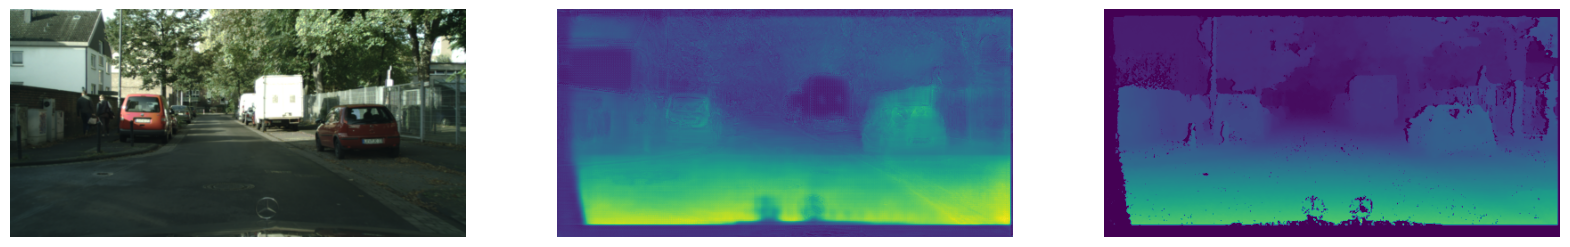

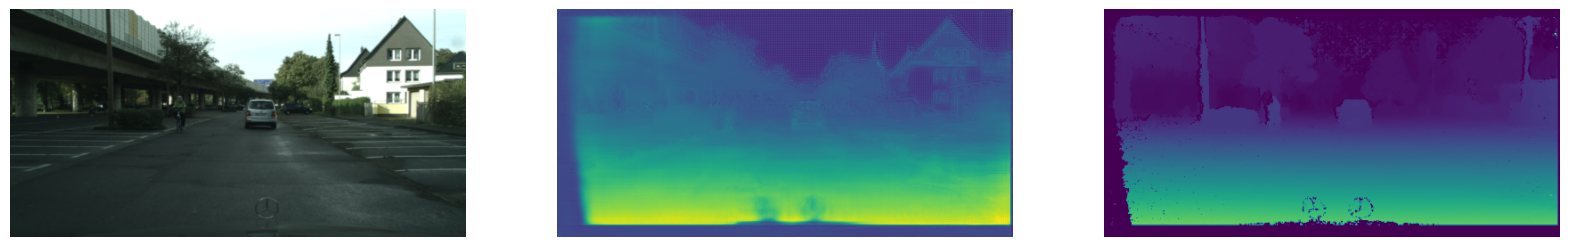

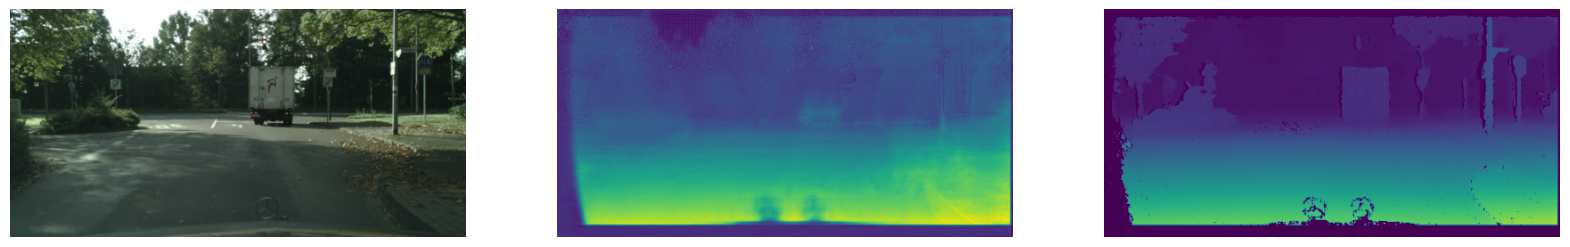

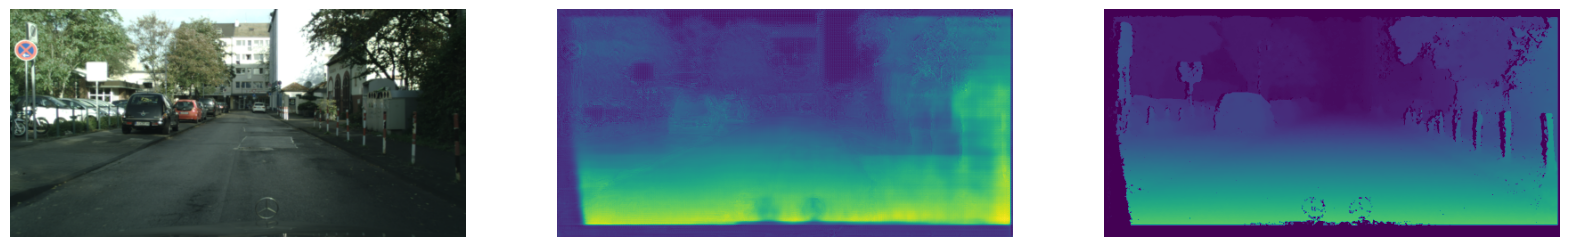

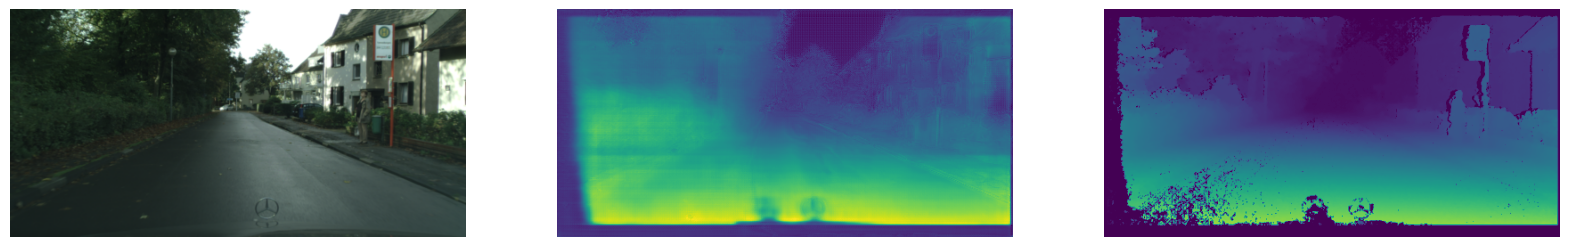

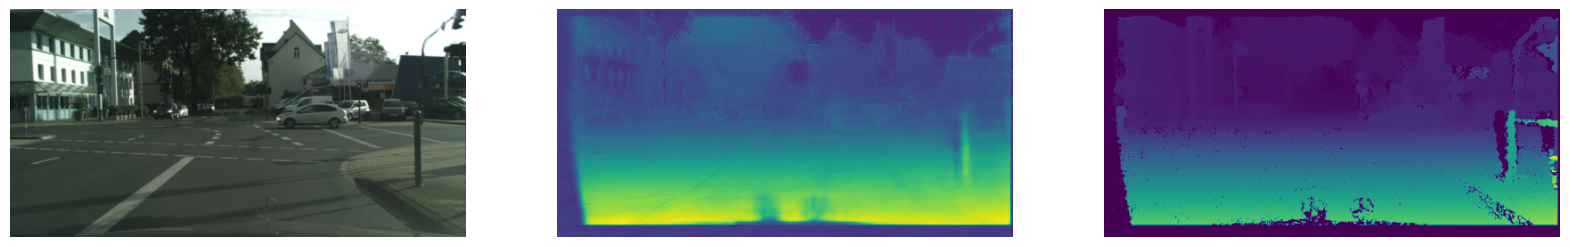

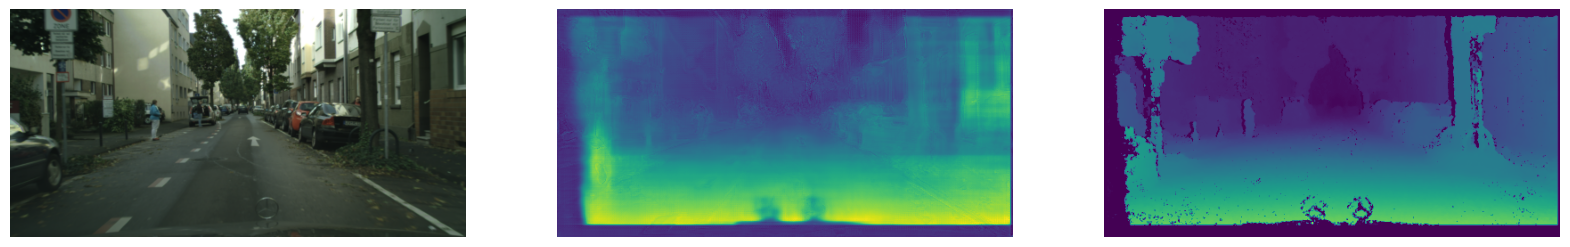

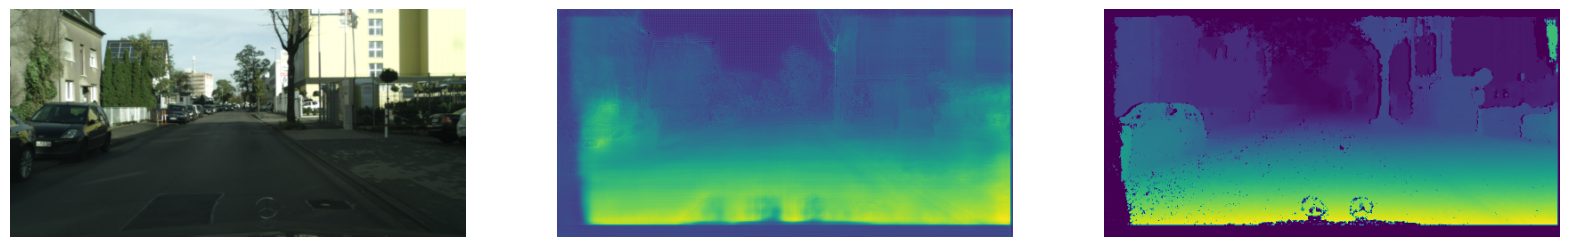

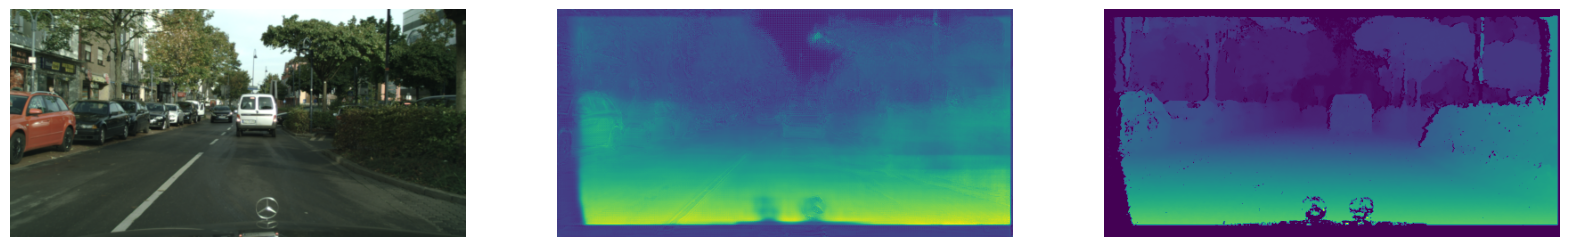

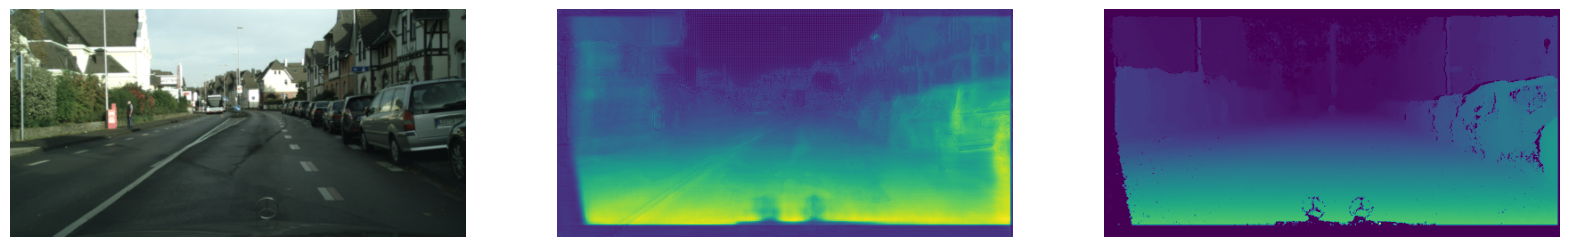

In [15]:
model.eval()

with torch.no_grad():
    for test_case_idx in range(10):
        test_img, test_depth = test_fine_ds[test_case_idx]
        test_img = test_img.unsqueeze(dim=0).to(device)
        test_depth = test_depth['depth']

        test_depth_fake = model(test_img)     
        f, axarr = plt.subplots(1, 3, figsize = (20,15))
        axarr[0].imshow(test_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(test_depth_fake[0].permute(1, -1, 0).cpu().numpy())
        axarr[1].axis('off')
        axarr[2].imshow(test_depth.permute(1, -1, 0).cpu().numpy())
        axarr[2].axis('off')